#Análisis de la varianza (ANOVA)
La prueba t funciona bien cuando se trata de dos grupos, pero a veces queremos comparar más de dos grupos al mismo tiempo. Por ejemplo, si quisiéramos probar si la edad de los votantes difiere en función de alguna variable categórica como la raza, tenemos que comparar las medias de cada nivel o agrupar la variable. Podríamos realizar una prueba t separada para cada par de grupos, pero cuando se realiza muchas pruebas, aumenta las posibilidades de falsos positivos. El análisis de varianza o ANOVA es una prueba de inferencia estadística que le permite comparar varios grupos al mismo tiempo.

El ANOVA unidireccional prueba si la media de alguna variable numérica difiere entre los niveles de una variable categórica. Esencialmente responde a la pregunta: ¿alguna de las medias grupales difiere entre sí? ¿Hay alguna muestra diferente al resto? No entraremos en los detalles de realizar un ANOVA a mano, ya que implica más cálculos que la prueba t, pero el proceso es similar: realiza varios cálculos para llegar a una estadística de prueba y luego compara el estadísticoa a un valor crítico basado en una distribución de probabilidad. En el caso del ANOVA, se utiliza la distribución F de Snedecor.

La biblioteca scipy tiene una función para realizar pruebas ANOVA unidireccionales llamada scipy.stats.f_oneway().

Generemos algunos datos demográficos y de edad de votantes falsos y usemos el ANOVA para comparar las edades promedio entre los grupos:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import math
from distfit import distfit
from itertools import combinations
import pycountry_convert as pc
from scipy.stats import levene


In [2]:
np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

El resultado de la prueba arroja una estadística F de 1,774 y un valor p de 0,1317, lo que indica que no hay una diferencia significativa entre las medias de cada grupo.

Otra forma de realizar una prueba ANOVA es utilizar la biblioteca statsmodels, que permite especificar un modelo con una sintaxis de fórmula que refleja la utilizada por el lenguaje de programación R. Los usuarios de R pueden encontrar este método más familiar:

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


Como puede ver, el método statsmodels produjo la misma estadística F y valor P (enumerados como PR(<F)) que el método stats.f_oneway.

Ahora hagamos datos de la nueva era donde las medias del grupo difieren y ejecutemos un segundo ANOVA:

In [4]:
np.random.seed(12)

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Use a different distribution for white ages
white_ages = stats.poisson.rvs(loc=18,
                              mu=35,
                              size=1000)

asian_ages = stats.poisson.rvs(loc=18,
                              mu=35,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age)
voter_age = np.where(voter_race=="asian", asian_ages, voter_age)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=46.01057867253624, pvalue=1.6859643907392802e-35)

In [5]:
# Alternate method
model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)


                sum_sq     df          F        PR(>F)
race       5819.832736    4.0  46.010579  1.685964e-35
Residual  31464.142264  995.0        NaN           NaN


El resultado de la prueba sugiere que los grupos no tienen las mismas medias muestrales en este caso, ya que el valor p es significativo con un nivel de confianza del 99 %. Sabemos que son los votantes blancos los que difieren porque lo configuramos de esa manera en el código, pero al probar datos reales, es posible que no sepa qué grupo o grupos hicieron que la prueba arrojara un resultado positivo.
Para verificar qué grupos difieren después de obtener un resultado ANOVA positivo, se puede realizar una prueba de seguimiento o "prueba post-hoc".

Una prueba post-hoc es realizar una prueba t separada para cada par de grupos. Puede realizar una prueba t entre todos los pares ejecutando cada par a través de stats.ttest_ind() que cubrimos en la lección sobre pruebas t:

In [6]:
# Get all race pairs
race_pairs = []

for race1 in range(4):
    for race2  in range(race1+1,5):
        race_pairs.append((races[race1], races[race2]))

# Conduct t-test on each pair
for race1, race2 in race_pairs:
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]],
                          voter_age[groups[race2]]))

asian black
TtestResult(statistic=5.343820392683496, pvalue=2.601526829511173e-07, df=189.0)
asian hispanic
TtestResult(statistic=5.368434775713779, pvalue=1.6448045844688444e-07, df=286.0)
asian other
TtestResult(statistic=4.825655352179236, pvalue=5.519219354634501e-06, df=92.0)
asian white
TtestResult(statistic=0.2343530107247312, pvalue=0.8147970516912304, df=557.0)
black hispanic
TtestResult(statistic=-1.003613423850229, pvalue=0.31618885561490895, df=389.0)
black other
TtestResult(statistic=0.07812368756106107, pvalue=0.9378097706428982, df=195.0)
black white
TtestResult(statistic=-9.587041333046411, pvalue=1.8126652471003016e-20, df=660.0)
hispanic other
TtestResult(statistic=0.7896415762636464, pvalue=0.43037785705783393, df=292.0)
hispanic white
TtestResult(statistic=-10.479803303818999, pvalue=4.34015994724495e-24, df=757.0)
other white
TtestResult(statistic=-6.224350033585383, pvalue=9.453030794367536e-10, df=563.0)


Los valores p para cada prueba t por pares sugieren que la media de los votantes blancos es probablemente diferente de los otros grupos, ya que los valores p para cada prueba t que involucra al grupo blanco es inferior a 0,05. Sin embargo, el uso de pruebas t por pares no ajustadas puede sobrestimar la importancia, porque cuantas más comparaciones haga, más probable es que encuentre un resultado poco probable debido a la casualidad. Podemos ajustar este problema de comparación múltiple dividiendo el nivel de significación estadística por el número de comparaciones realizadas. En este caso, si estuviéramos buscando un nivel de significación del 5 %, estaríamos buscando valores de p de 0,05/10 = 0,005 o menos. Este ajuste simple para comparaciones múltiples se conoce como la corrección de Bonferroni.

La corrección de Bonferroni es un enfoque conservador para dar cuenta del problema de comparaciones múltiples que puede terminar rechazando resultados que en realidad son significativos. Otra prueba post hoc común es la prueba de Tukey. Puede realizar la prueba de Tukey usando la función pairwise_tukeyhsd() en la biblioteca statsmodels.stats.multicomp:

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-5.3493,0.0,-7.99,-2.7085,True
asian,hispanic,-4.7645,0.0,-7.2815,-2.2476,True
asian,other,-5.4227,0.0,-8.5993,-2.2462,True
asian,white,-0.2091,0.9993,-2.6228,2.2045,False
black,hispanic,0.5847,0.8572,-1.0198,2.1892,False
black,other,-0.0735,1.0,-2.5894,2.4424,False
black,white,5.1401,0.0,3.7031,6.5772,True
hispanic,other,-0.6582,0.9435,-3.0438,1.7274,False
hispanic,white,4.5554,0.0,3.3611,5.7497,True
other,white,5.2136,0.0,2.9372,7.4899,True


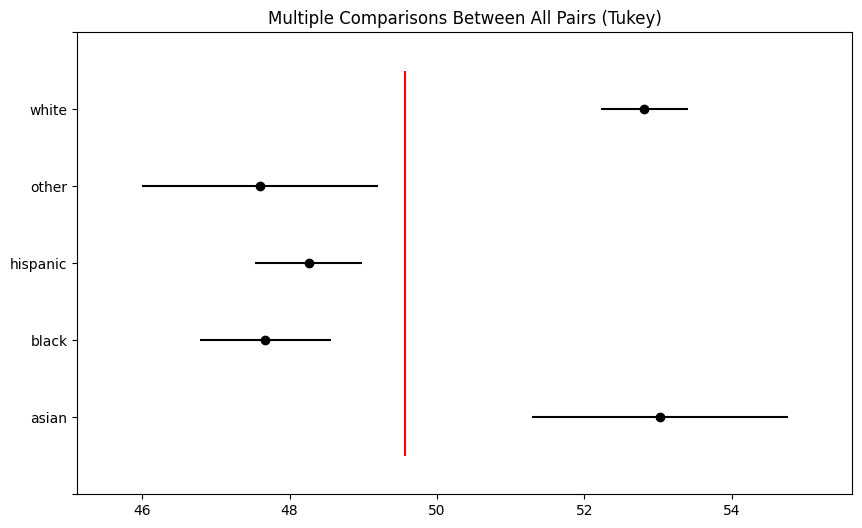

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,     # Data
                          groups=voter_race,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

El resultado de la prueba de Tukey muestra la diferencia promedio, un intervalo de confianza y si debe rechazar la hipótesis nula para cada par de grupos en el nivel de significación dado. En este caso, la prueba sugiere que rechacemos la hipótesis nula para 3 pares, y cada par incluye la categoría "blanca". Esto sugiere que el grupo blanco probablemente sea diferente de los demás. También ocurre lo mismo con "asian" Parece que hay dos grupos distintos, uno englobando asian y white, y otro englobando el resto . La gráfica del intervalo de confianza del 95 % refuerza los resultados visualmente: solo el intervalo de confianza de otro grupo se superpone al intervalo de confianza del grupo blanco.

#Resumen

La prueba ANOVA nos permite comprobar si una variable de respuesta numérica varía según los niveles de una variable categórica. La biblioteca scipy de Python facilita la realización de un ANOVA sin profundizar demasiado en los detalles del procedimiento.

FIFA PLAYERS DATASET

In [8]:
fifa_all = pd.read_csv('./fifa_players.csv')
fifa_all.describe()

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
count,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,1.769900e+04,17708.000000,17954.000000,17954.000000,17954.000000,...,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000
mean,25.565445,174.946921,75.301047,66.240169,71.430935,2.479280e+06,9902.134628,1.111674,2.945695,2.361034,...,46.852456,55.816531,46.657959,49.857302,53.406260,48.357302,58.680183,47.162861,47.733040,45.705915
std,4.705708,14.029449,7.083684,6.963730,6.131339,5.687014e+06,21995.593750,0.392168,0.663691,0.763223,...,19.429337,17.394047,20.754649,19.694311,14.156038,15.810844,11.625541,20.037346,21.674973,21.285812
min,17.000000,152.400000,49.900000,47.000000,48.000000,1.000000e+04,1000.000000,1.000000,1.000000,1.000000,...,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,12.000000,3.000000,2.000000,3.000000
25%,22.000000,154.940000,69.900000,62.000000,67.000000,3.250000e+05,1000.000000,1.000000,3.000000,2.000000,...,32.000000,44.000000,26.000000,38.000000,44.000000,38.000000,51.000000,30.000000,27.000000,24.000000
50%,25.000000,175.260000,74.800000,66.000000,71.000000,7.000000e+05,3000.000000,1.000000,3.000000,2.000000,...,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,52.500000,55.000000,52.000000
75%,29.000000,185.420000,79.800000,71.000000,75.000000,2.100000e+06,9000.000000,1.000000,3.000000,3.000000,...,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000
max,46.000000,205.740000,110.200000,94.000000,95.000000,1.105000e+08,565000.000000,5.000000,5.000000,5.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,93.000000,90.000000


In [9]:
fifa_all

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17949,R. McKenzie,Rory McKenzie,10/7/1993,25,175.26,74.8,"RM,CAM,CM",Scotland,67,70,...,54,69,41,60,64,63,56,40,20,18
17950,M. Sipľak,Michal Sipľak,2/2/1996,23,182.88,79.8,LB,Slovakia,59,67,...,22,62,55,42,39,32,52,53,64,60
17951,J. Bekkema,Jan Bekkema,4/9/1996,22,185.42,89.8,GK,Netherlands,59,67,...,9,27,10,5,25,16,47,9,12,13
17952,A. Al Yami,Abdulrahman Al Yami,6/19/1997,21,175.26,64.9,"ST,LM",Saudi Arabia,59,71,...,58,38,15,54,52,50,53,16,18,17


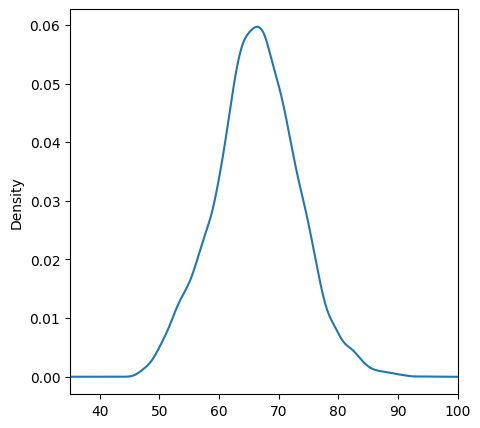

In [10]:
fifa_all["overall_rating"].plot(kind="density",  # Create density plot
                      figsize=(5,5),    # Set figure size
                      xlim= (35, 100));

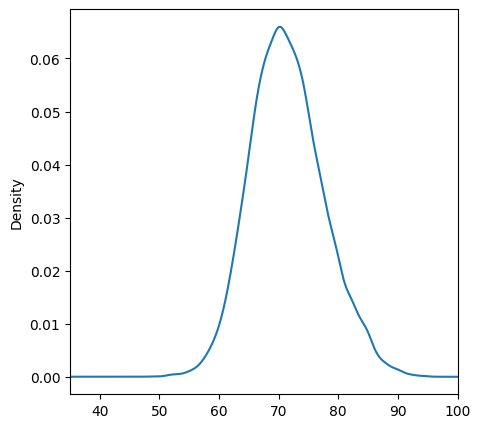

In [11]:
fifa_all["potential"].plot(kind="density",  # Create density plot
                      figsize=(5,5),    # Set figure size
                      xlim= (35, 100));

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0285408] [loc=66.240 scale=6.964]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0667404] [loc=47.000 scale=19.240]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0667404] [loc=-8589934545.000 scale=8589934592.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 0.0265251] [loc=66.471 scale=5.927]
[distfit] >INFO> [t         ] [0.45 sec] [RSS: 0.0285001] [loc=66.237 scale=6.870]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.0290305] [loc=63.567 scale=6.875]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 0.0285517] [loc=-244.931 scale=0.156]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0285514] [loc=-401.000 scale=467.189]
[distfit] >INFO> [beta      ] [0.08 sec] [RSS: 0.0285577] [loc=-177.378 scale=1829062.236]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0575737] [loc=47.000 scale=47.000]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 0.0285566] [loc=-1346.025 scale=208.166]


          name     score           loc              scale  \
0     dweibull  0.026525     66.470763           5.927086   
1            t    0.0285     66.236746           6.870101   
2         norm  0.028541     66.240169           6.963536   
3      lognorm  0.028551   -401.000421         467.188709   
4        gamma  0.028552    -244.93088           0.155836   
5     loggamma  0.028557  -1346.024579         208.166223   
6         beta  0.028558   -177.377664     1829062.236116   
7   genextreme  0.029031     63.567345           6.875011   
8      uniform  0.057574          47.0               47.0   
9       pareto   0.06674 -8589934545.0  8589934591.999999   
10       expon   0.06674          47.0          19.240169   

                                        arg  \
0                      (1.268340801662309,)   
1                      (74.89892874839123,)   
2                                        ()   
3                   (0.014902629761614052,)   
4                      (1996.780

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.26834, loc=66.4708, scale=5.92709)'}, xlabel='Values', ylabel='Frequency'>)

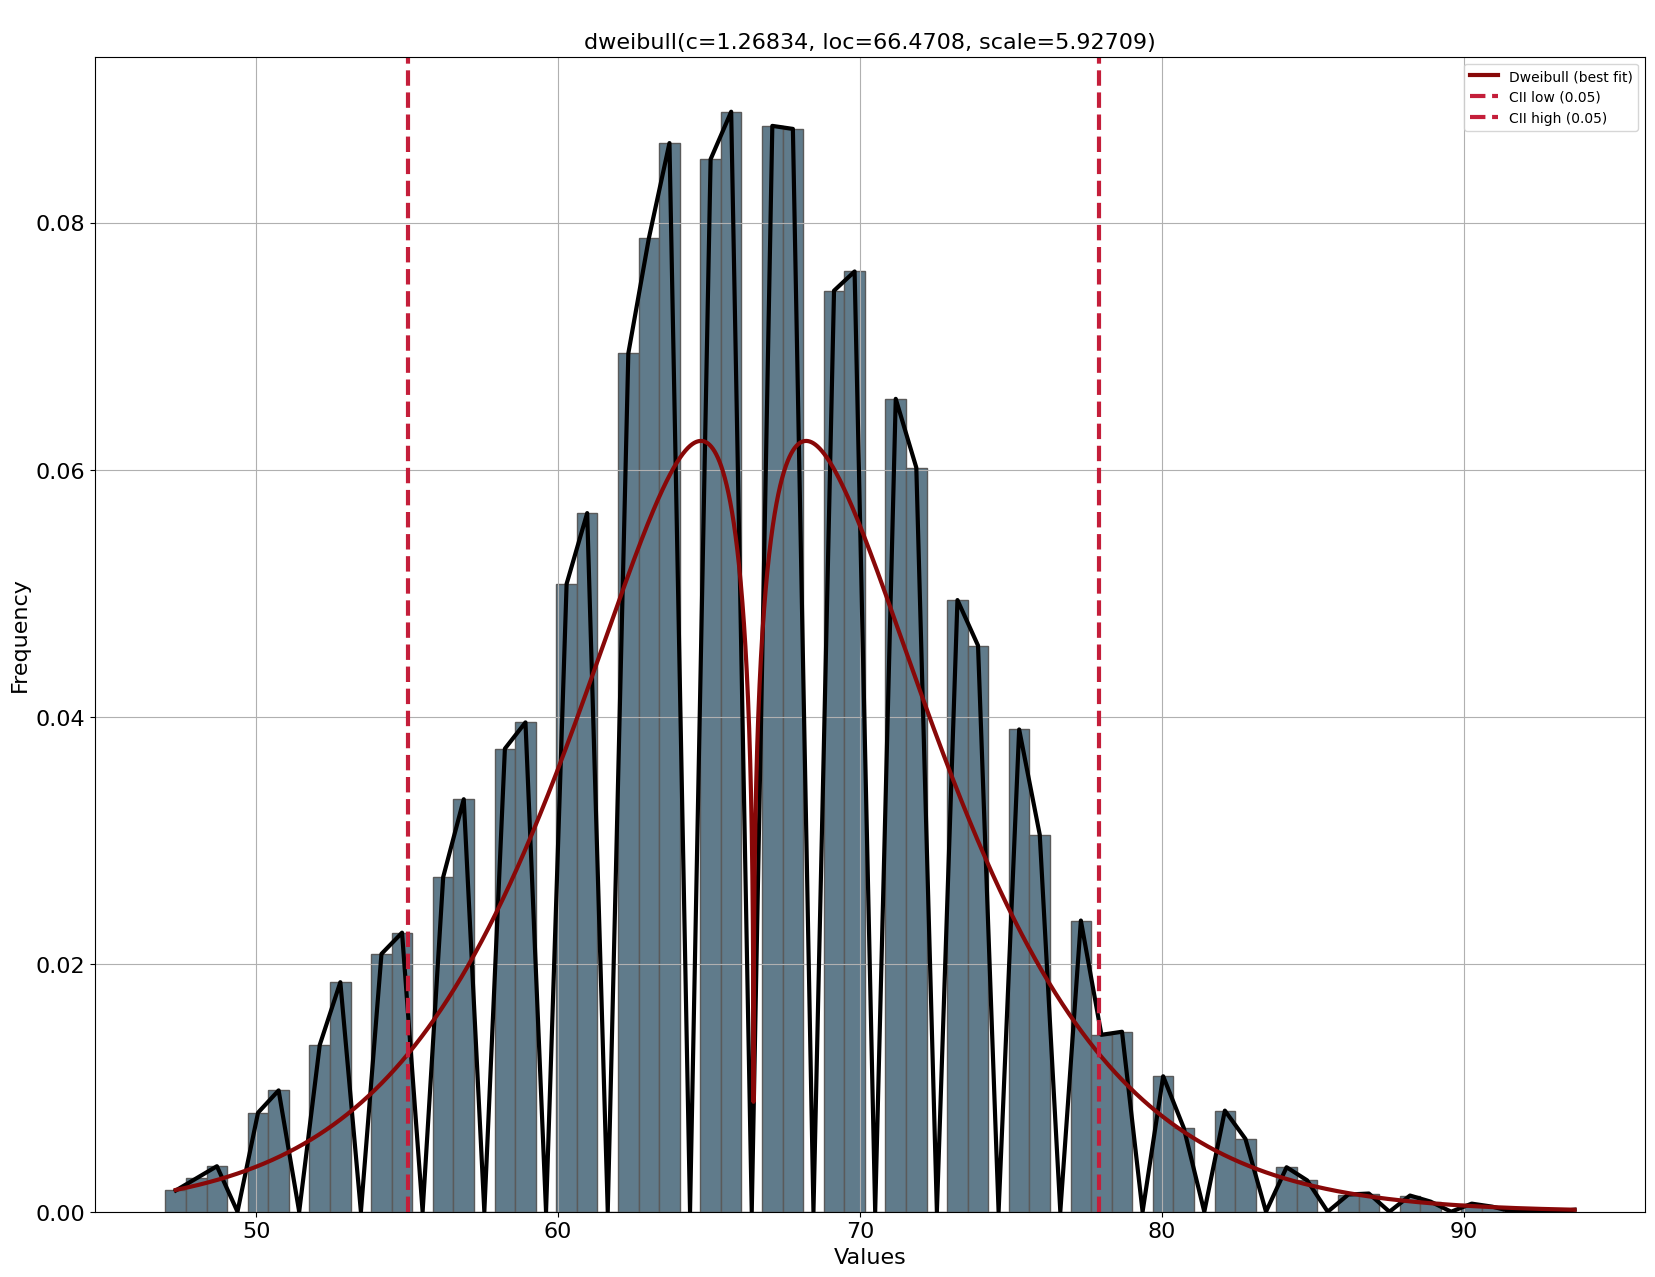

In [12]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your BMI data
dist.fit_transform(fifa_all['overall_rating'])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0492448] [loc=71.431 scale=6.131]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.106381] [loc=48.000 scale=23.431]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.106381] [loc=-4294967248.000 scale=4294967296.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.0474781] [loc=71.481 scale=5.299]
[distfit] >INFO> [t         ] [0.47 sec] [RSS: 0.0492506] [loc=71.436 scale=6.134]
[distfit] >INFO> [genextreme] [0.29 sec] [RSS: 0.0487975] [loc=69.050 scale=5.859]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.0487556] [loc=22.709 scale=0.771]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0487446] [loc=0.528 scale=70.639]
[distfit] >INFO> [beta      ] [0.18 sec] [RSS: 0.0487596] [loc=27.934 scale=454.070]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0903909] [loc=48.000 scale=47.000]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.0493862] [loc=-1238.043 scale=190.818]
[distfit] >INF

          name     score           loc         scale  \
0     dweibull  0.047478     71.480945      5.298773   
1      lognorm  0.048745      0.527909     70.639469   
2        gamma  0.048756     22.708593      0.770968   
3         beta   0.04876     27.933833    454.069529   
4   genextreme  0.048797     69.049667      5.858562   
5         norm  0.049245     71.430935      6.131168   
6            t  0.049251     71.435853      6.133754   
7     loggamma  0.049386  -1238.042945    190.818032   
8      uniform  0.090391          48.0          47.0   
9       pareto  0.106381 -4294967248.0  4294967296.0   
10       expon  0.106381          48.0     23.430935   

                                      arg  \
0                     (1.30988514349247,)   
1                  (0.08629897825825433,)   
2                   (63.196349320746066,)   
3   (45.417591245517, 428.68246353673976)   
4                  (0.20014762002175973,)   
5                                      ()   
6           

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.30989, loc=71.4809, scale=5.29877)'}, xlabel='Values', ylabel='Frequency'>)

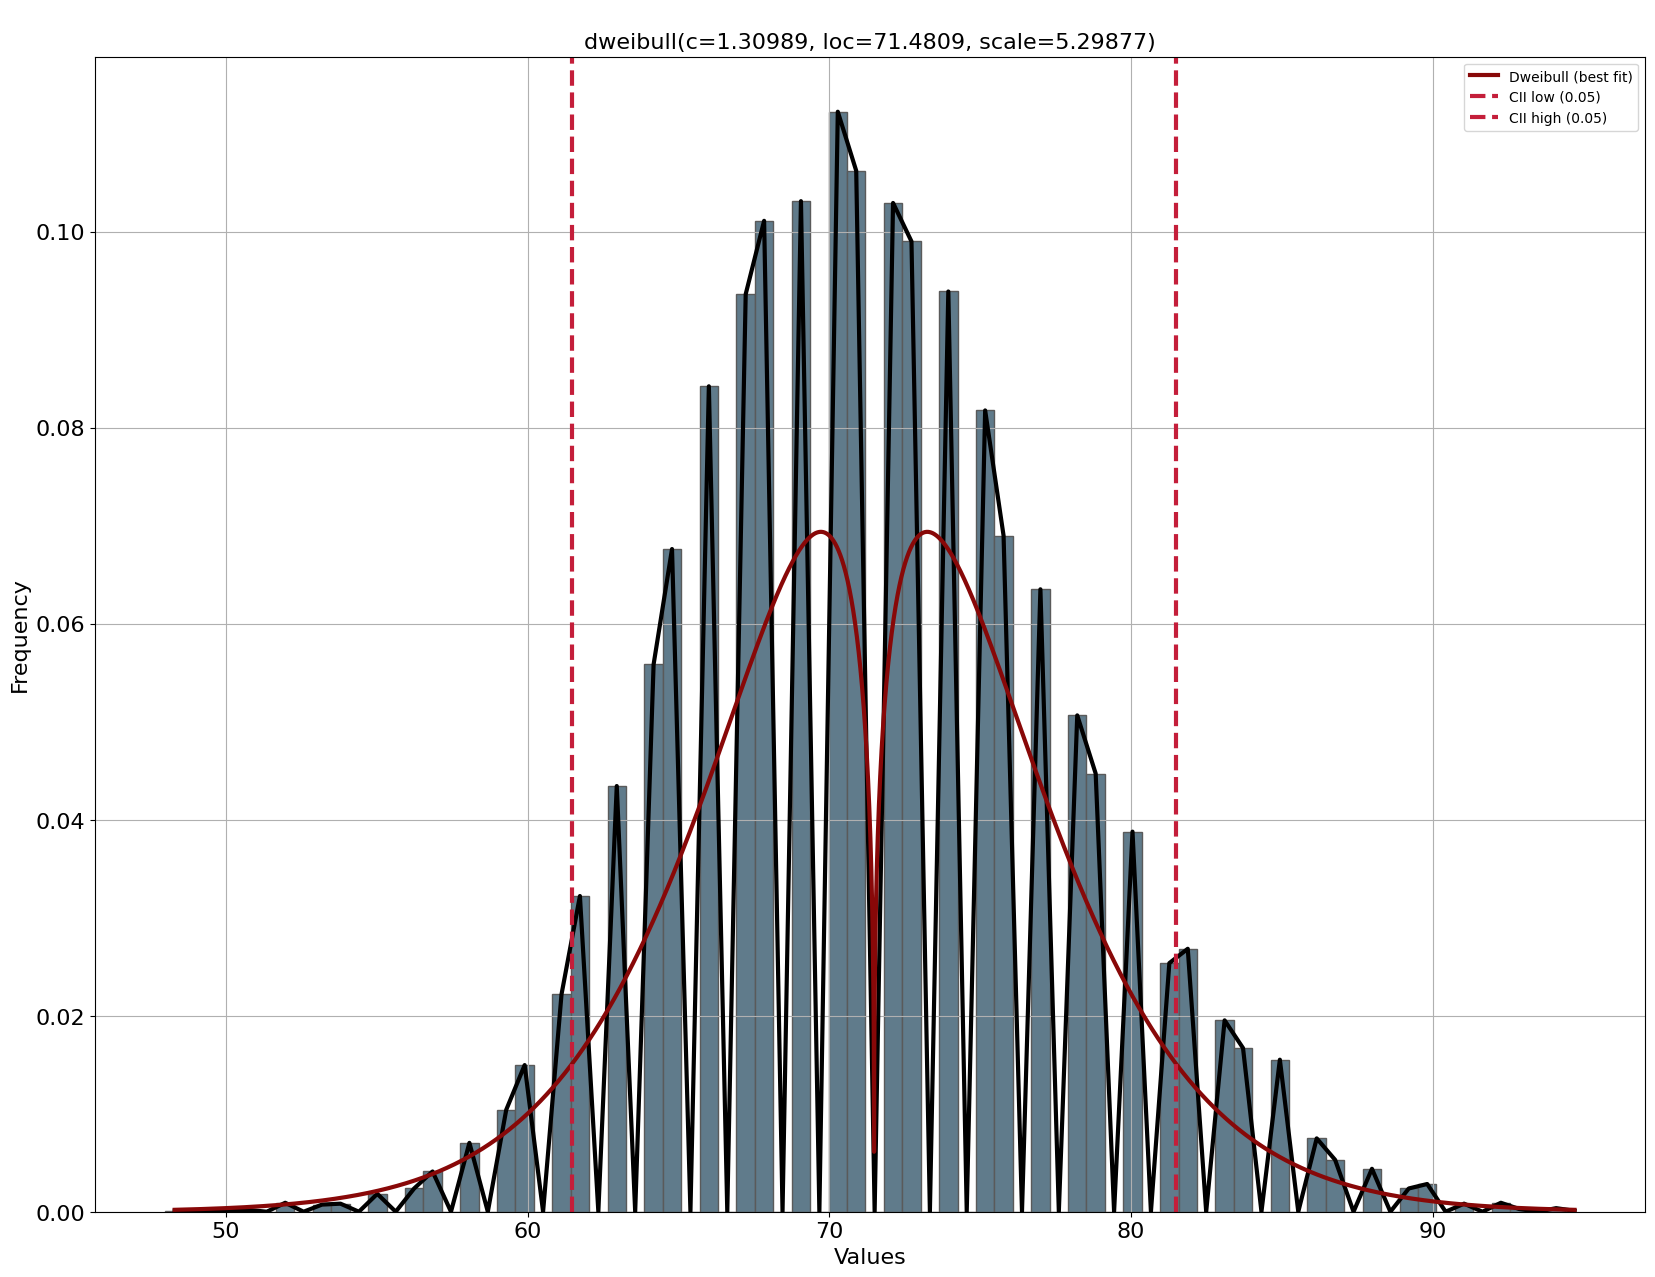

In [13]:
# Initialize distfit
dist = distfit()

# Fit the distribution to your BMI data
dist.fit_transform(fifa_all['potential'])

# Print the summary of the best fit distribution
print(dist.summary)

# Optionally, you can also plot the best fit distribution against your data
dist.plot()

In [14]:
# Suponiendo que tienes un DataFrame df con una columna 'country' que contiene los nombres de los países

# Definir una función para obtener el continente de un país
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

# Aplicar la función a la columna 'country' para obtener el continente correspondiente
fifa_all['continent'] = fifa_all['nationality'].apply(get_continent)

# Ahora, fifa_all contiene una nueva columna 'continent' que indica el continente al que pertenece cada país

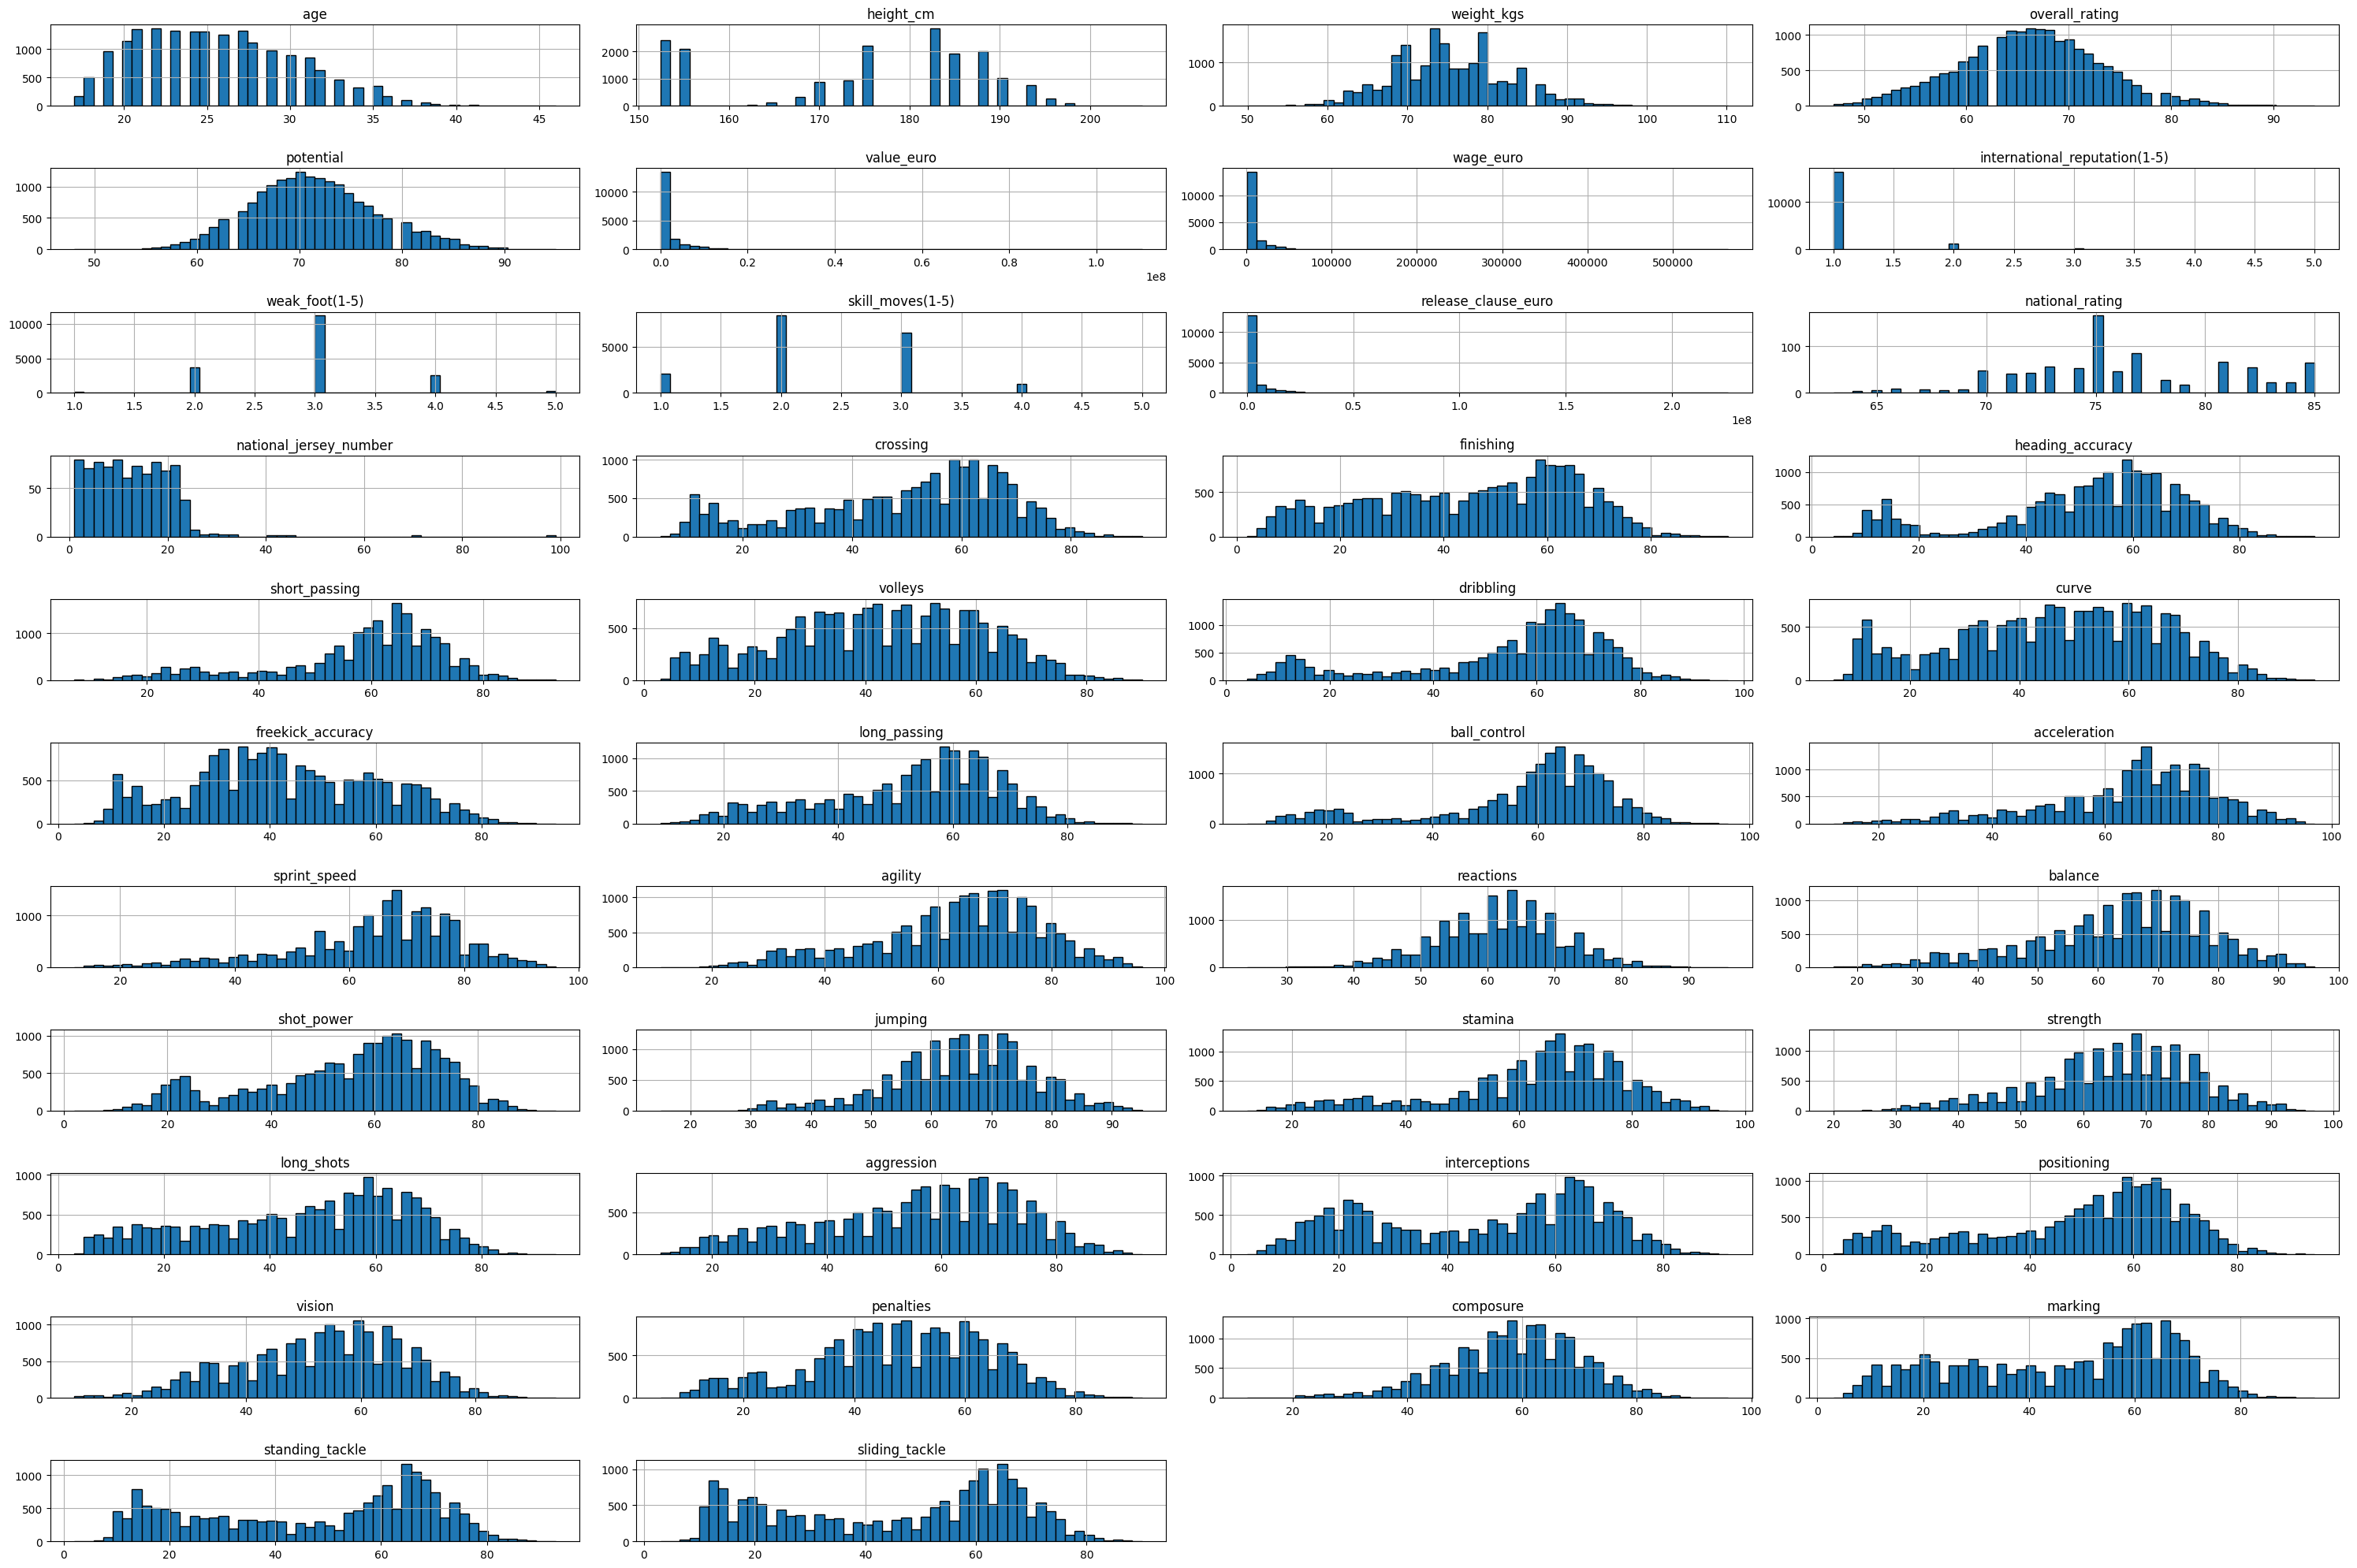

In [15]:
fifa_all.hist(figsize=(30, 20), bins=50, layout=(-1, 4), edgecolor='black')
plt.tight_layout()
plt.show()

In [16]:
# ANOVA nationality vs overall_rating
model = ols('overall_rating ~ nationality',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                    sum_sq       df          F  PR(>F)
nationality  160414.369128    159.0  25.278143     0.0
Residual     710190.020757  17794.0        NaN     NaN


In [17]:
# ANOVA continent vs overall_rating
model = ols('overall_rating ~ continent',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                  sum_sq       df           F         PR(>F)
continent   30811.257123      5.0  137.523224  5.932954e-143
Residual   649279.596906  14490.0         NaN            NaN


In [18]:
# ANOVA positions vs overall_rating
model = ols('overall_rating ~ positions',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                  sum_sq       df        F        PR(>F)
positions   87651.731009    889.0  2.14884  1.648079e-70
Residual   782952.658876  17064.0      NaN           NaN


In [19]:
# ANOVA nationality vs potential
model = ols('potential ~ nationality',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                    sum_sq       df          F  PR(>F)
nationality  116721.544186    159.0  23.401539     0.0
Residual     558191.314731  17794.0        NaN     NaN


In [20]:
# ANOVA continent vs potential
model = ols('potential ~ continent',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                  sum_sq       df           F         PR(>F)
continent   24969.612722      5.0  148.253913  5.206264e-154
Residual   488094.621274  14490.0         NaN            NaN


In [21]:
# ANOVA positions vs potential
model = ols('potential ~ positions',                 # Model formula
            data = fifa_all).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                  sum_sq       df        F        PR(>F)
positions   58145.682520    889.0  1.80957  4.518124e-41
Residual   616767.176398  17064.0      NaN           NaN


POST HOCs

In [22]:
# Group by nationality
nationality_groups = fifa_all.groupby("nationality")

# Create all unique pairs of nationalities
nationality_pairs = list(combinations(nationality_groups.groups.keys(), 2))

# Initialize a list to store t-test results
t_test_nat_results = []

# Conduct t-test on each pair
for nat1, nat2 in nationality_pairs:
    data1 = nationality_groups.get_group(nat1)['overall_rating']
    data2 = nationality_groups.get_group(nat2)['overall_rating']
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Assuming unequal variance
    t_test_nat_results.append((nat1, nat2, t_stat, p_value))

# Convert the results to a DataFrame for better readability
t_test_nat_results_df = pd.DataFrame(t_test_nat_results, columns=['Nationality 1', 'Nationality 2', 'T-Statistic', 'P-Value'])

# Display the DataFrame
print(t_test_nat_results_df)  # Display the first few rows as an example

      Nationality 1      Nationality 2  T-Statistic   P-Value
0       Afghanistan            Albania    -3.144465  0.032865
1       Afghanistan            Algeria    -6.313969  0.006119
2       Afghanistan            Andorra          NaN       NaN
3       Afghanistan             Angola    -3.899567  0.005463
4       Afghanistan  Antigua & Barbuda    -0.541665  0.613120
...             ...                ...          ...       ...
12715         Wales             Zambia    -0.721461  0.484340
12716         Wales           Zimbabwe    -3.183161  0.005600
12717         Yemen             Zambia          NaN       NaN
12718         Yemen           Zimbabwe          NaN       NaN
12719        Zambia           Zimbabwe    -1.825590  0.082671

[12720 rows x 4 columns]


In [23]:
# Group by continent
fifa_all = fifa_all.dropna(subset = ['continent'])
continent_groups = fifa_all.groupby("continent")

# Create all unique pairs of nationalities
continent_pairs = list(combinations(continent_groups.groups.keys(), 2))

# Initialize a list to store t-test results
t_test_cont_results = []

# Conduct t-test on each pair
for cont1, cont2 in continent_pairs:
    data1 = continent_groups.get_group(cont1)['overall_rating']
    data2 = continent_groups.get_group(cont2)['overall_rating']
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Assuming unequal variance
    t_test_cont_results.append((cont1, cont2, t_stat, p_value))

# Convert the results to a DataFrame for better readability
t_test_cont_results_df = pd.DataFrame(t_test_cont_results, columns=['Continent 1', 'Continent 2', 'T-Statistic', 'P-Value'])

# Display the DataFrame
print(t_test_cont_results_df.head())  # Display the first few rows as an example

  Continent 1    Continent 2  T-Statistic       P-Value
0      Africa           Asia    19.466841  2.123087e-78
1      Africa         Europe     5.314644  1.214155e-07
2      Africa  North America    11.184582  3.985997e-28
3      Africa        Oceania    13.772766  7.481509e-36
4      Africa  South America    -0.036743  9.706930e-01


In [24]:
# Group by positions
# Note: Since players can have multiple positions, here we consider just their primary position.
fifa_all['primary_position'] = fifa_all['positions'].apply(lambda x: x.split(',')[0])
position_groups = fifa_all.groupby("primary_position")

# Create all unique pairs of positions
position_pairs = list(combinations(position_groups.groups.keys(), 2))

# Initialize a list to store t-test results
t_test_results_positions = []

# Conduct t-test on each pair
for pos1, pos2 in position_pairs:
    data1 = position_groups.get_group(pos1)['overall_rating']
    data2 = position_groups.get_group(pos2)['overall_rating']
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Assuming unequal variance
    t_test_results_positions.append((pos1, pos2, t_stat, p_value))

# Convert the results to a DataFrame for better readability
t_test_results_positions_df = pd.DataFrame(t_test_results_positions, columns=['Position 1', 'Position 2', 'T-Statistic', 'P-Value'])

# Display the DataFrame
print(t_test_results_positions_df.head())  # Display the first few rows as an example


  Position 1 Position 2  T-Statistic       P-Value
0        CAM         CB     1.071071  2.843154e-01
1        CAM        CDM    -0.744075  4.569284e-01
2        CAM         CF    -0.966518  3.364389e-01
3        CAM         CM     3.951542  8.050987e-05
4        CAM         GK     8.637739  1.183974e-17


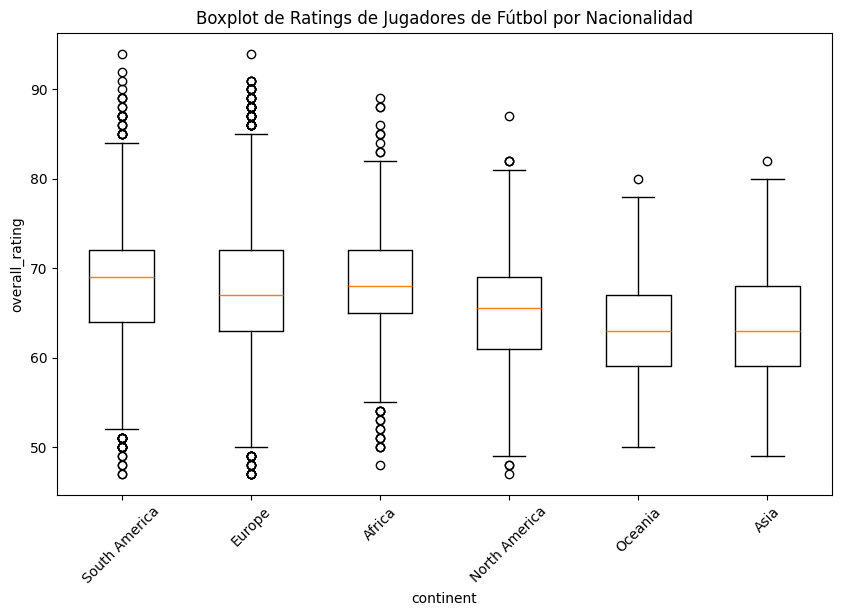

In [25]:
# Boxplot by continent
fifa_all = fifa_all.dropna(subset=['continent'])
plt.figure(figsize=(10, 6))
plt.boxplot([fifa_all[fifa_all['continent'] == nationality]['overall_rating'] for nationality in fifa_all['continent'].unique()], 
            labels=fifa_all['continent'].unique())
plt.xlabel('continent')
plt.ylabel('overall_rating')
plt.title('Boxplot de Ratings de Jugadores de Fútbol por Nacionalidad')
plt.xticks(rotation=45)
plt.show()

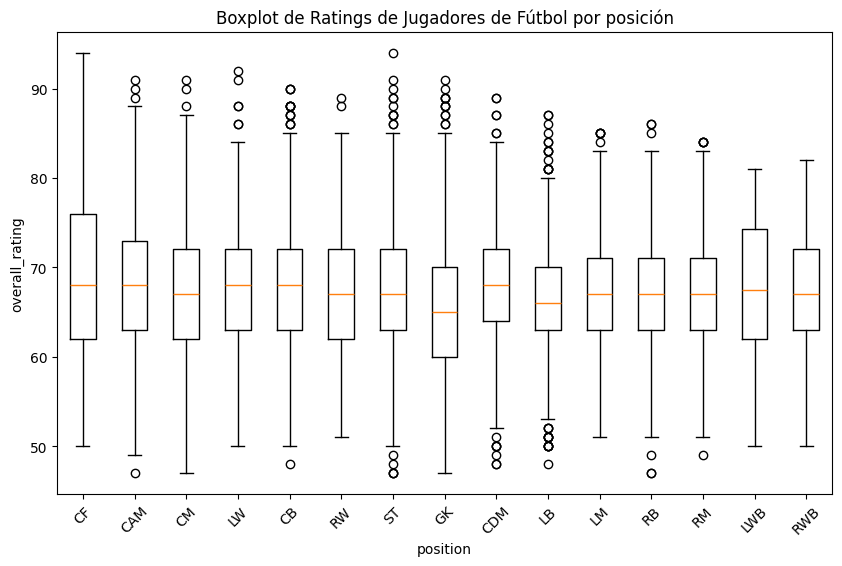

In [26]:
# Boxplot by primary positions
#fifa_all = fifa_all.dropna(subset=['primary_position'])
plt.figure(figsize=(10, 6))
plt.boxplot([fifa_all[fifa_all['primary_position'] == primary_position]['overall_rating'] for primary_position in fifa_all['primary_position'].unique()], 
            labels=fifa_all['primary_position'].unique())
plt.xlabel('position')
plt.ylabel('overall_rating')
plt.title('Boxplot de Ratings de Jugadores de Fútbol por posición')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Agrupar los datos por continente y calcular la varianza de 'overall_rating' para cada grupo
grouped = fifa_all.groupby('continent')['overall_rating'].apply(list)

# Convertir los datos en una lista de listas
data = [group for group in grouped]

# Aplicar la prueba de Levene desempaquetando los datos
statistic, p_value = levene(*data)

# Imprimir los resultados
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)

Estadístico de Levene: 11.620993408965496
Valor p: 3.153276520085977e-11


In [28]:
# Agrupar los datos por posición y calcular la varianza de 'overall_rating' para cada grupo
grouped = fifa_all.groupby('primary_position')['overall_rating'].apply(list)

# Convertir los datos en una lista de listas
data = [group for group in grouped]

# Aplicar la prueba de Levene desempaquetando los datos
statistic, p_value = levene(*data)

# Imprimir los resultados
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)

Estadístico de Levene: 15.89916153852557
Valor p: 2.755061272674813e-39
